In [4]:
## Importing packages that will be used ##
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [5]:
### Parsing the Hurdat2 Dataset ###
storms = []
with open('Data/hurdat2_8_28_25.csv') as hurdat2:
    info = hurdat2.readlines()
i = 0
while i < len(info):
    line = info[i].strip().split(',')
    storm_id = line[0].strip()
    storm_name = line[1].strip()
    track_entries = int(line[2].strip())
    year = storm_id[-4:]

    tracks = [info[j].strip().split(',') for j in range(i+1, i+1+track_entries)]
    df = pd.DataFrame(tracks, columns = ["date", "time", "ID", "Cylcone Type", "Lat", "lon",
                                              "Max Winds", "Min Pressure", "34kt NEQ", "34kt SEQ", 
                                              "34kt SWQ", "34kt NWQ", "50kt NEQ", "50kt SEQ", "50kt SWQ",
                                              "50kt NWQ", "64kt NEQ", "64kt SEQ","64kt SWQ", "64kt NWQ", 
                                              "Radius of Max Winds"])
    df["storm_id"] = storm_id
    df["storm_name"] = storm_name
    df["year"] = year

    if any(id.strip() == "L" for id in df["ID"].values):
        storms.append(df)
    i += track_entries + 1
       
Landfalling_storms = pd.concat(storms, ignore_index = True)



In [6]:
### Just seeing the Datframe ###
Landfalling_storms

,date,time,ID,Cylcone Type,Lat,lon,Max Winds,Min Pressure,34kt NEQ,34kt SEQ,...,50kt SWQ,50kt NWQ,64kt NEQ,64kt SEQ,64kt SWQ,64kt NWQ,Radius of Max Winds,storm_id,storm_name,year
0,18510625,0000,,HU,28.0N,94.8W,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,AL011851,UNNAMED,1851
1,18510625,0600,,HU,28.0N,95.4W,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,AL011851,UNNAMED,1851
2,18510625,1200,,HU,28.0N,96.0W,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,AL011851,UNNAMED,1851
3,18510625,1800,,HU,28.1N,96.5W,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,AL011851,UNNAMED,1851
4,18510625,2100,L,HU,28.2N,96.8W,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,AL011851,UNNAMED,1851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22832,20241117,0600,,TS,16.5N,87.5W,35,1001,80,30,...,0,0,0,0,0,0,40,AL192024,SARA,2024
22833,20241117,1200,,TS,16.8N,87.9W,35,1001,80,30,...,0,0,0,0,0,0,40,AL192024,SARA,2024
22834,20241117,1400,L,TS,17.0N,88.3W,35,1001,80,30,...,0,0,0,0,0,0,40,AL192024,SARA,2024
22835,20241117,1800,,TD,17.4N,89.1W,30,1003,0,0,...,0,0,0,0,0,0,50,AL192024,SARA,2024


In [7]:
### Altering the Dataframe ###
Landfalling_storms['date'] = pd.to_datetime(Landfalling_storms['date'], dayfirst = "True",)
Landfall_only = Landfalling_storms[Landfalling_storms["ID"].str.strip() == "L"] # Showing only the landfalls for each storm
Landfall_only = Landfall_only.set_index(['storm_name', 'date', 'storm_id']) ## Setting a multi-index with storm name and year
Landfall_only = Landfall_only.drop(columns = ['ID']) # Dropping ID and Storm_id cause they are no longer needed

### Converting Maximum winds in pandas dataset into Category of Storm ###
Landfall_only["Max Winds"] = pd.to_numeric(Landfall_only["Max Winds"].values)
#Landfall_only["Max Winds"] = Landfall_only["Max Winds"] * 1.15078 # ----> We do no need to convert to mph, however if needed uncomment this line and change the conditions below for MPH rather than knots
Landfall_only["category"] = np.select([
    Landfall_only["Max Winds"] <= 33, #38 mph 
    Landfall_only["Max Winds"] < 64, #73 mph
    Landfall_only["Max Winds"] < 82, #95 mph
    Landfall_only["Max Winds"] < 95, #110 mph
    Landfall_only["Max Winds"] < 113, #129 mph
    Landfall_only["Max Winds"] < 137, #156 mph
    Landfall_only["Max Winds"] >= 137, #157+ mph
], 
[
    "TD",
    "TS",
    "Cat 1",
    "Cat 2",
    "Cat 3",
    "Cat 4",
    "Cat 5"
],
default = 'Unknown')


C:\Users\edubp\AppData\Local\Temp\ipykernel_6892\3626277209.py:2: UserWarning: Parsing dates in %Y%m%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  Landfalling_storms['date'] = pd.to_datetime(Landfalling_storms['date'], dayfirst = "True",)


In [8]:
Landfall_only

time Cylcone Type     Lat      lon  \
storm_name date       storm_id                                        
UNNAMED    1851-06-25 AL011851   2100           HU   28.2N    96.8W   
           1851-08-23 AL041851   2100           HU   30.1N    85.7W   
           1851-10-19 AL061851   1500           TS   41.1N    71.7W   
           1852-08-26 AL011852   0600           HU   30.2N    88.6W   
           1852-09-12 AL031852   0000           HU   28.0N    82.8W   
...                               ...          ...     ...      ...   
OSCAR      2024-10-19 AL162024   2015           HU   21.5N    71.1W   
           2024-10-20 AL162024   2200           HU   20.3N    74.4W   
RAFAEL     2024-11-06 AL182024   2115           HU   22.7N    82.7W   
SARA       2024-11-15 AL192024   0120           TS   15.8N    84.3W   
           2024-11-17 AL192024   1400           TS   17.0N    88.3W   

                                Max Winds Min Pressure 34kt NEQ 34kt SEQ  \
storm_name date       storm_id                                             
UNNAMED    1851-06-25 AL011851         80         -999     -999     -999   
           1851-08-23 AL041851        100         -999     -999     -999   
           1851-10-19 AL061851         50         -999     -999     -999   
           1852-08-26 AL011852        100          961     -999     -999   
           1852-09-12 AL031852         70         -999     -999     -999   
...                                   ...          ...      ...      ...   
OSCAR      2024-10-19 AL162024         75          987       40       30   
           2024-10-20 AL162024         75          984       40       30   
RAFAEL     2024-11-06 AL182024        100          955      100       90   
SARA       2024-11-15 AL192024         40          999       90        0   
           2024-11-17 AL192024         35         1001       80       30   

                               34kt SWQ 34kt NWQ  ... 50kt SEQ 50kt SWQ  \
storm_name date       storm_id                    ...                     
UNNAMED    1851-06-25 AL011851     -999     -999  ...     -999     -999   
           1851-08-23 AL041851     -999     -999  ...     -999     -999   
           1851-10-19 AL061851     -999     -999  ...     -999     -999   
           1852-08-26 AL011852     -999     -999  ...     -999     -999   
           1852-09-12 AL031852     -999     -999  ...     -999     -999   
...                                 ...      ...  ...      ...      ...   
OSCAR      2024-10-19 AL162024       30       40  ...       10       10   
           2024-10-20 AL162024       30       40  ...       10       10   
RAFAEL     2024-11-06 AL182024       40       50  ...       40       20   
SARA       2024-11-15 AL192024        0       90  ...        0        0   
           2024-11-17 AL192024       30       60  ...        0        0   

                               50kt NWQ 64kt NEQ 64kt SEQ 64kt SWQ 64kt NWQ  \
storm_name date       storm_id                                                
UNNAMED    1851-06-25 AL011851     -999     -999     -999     -999     -999   
           1851-08-23 AL041851     -999     -999     -999     -999     -999   
           1851-10-19 AL061851     -999     -999     -999     -999     -999   
           1852-08-26 AL011852     -999     -999     -999     -999     -999   
           1852-09-12 AL031852     -999     -999     -999     -999     -999   
...                                 ...      ...      ...      ...      ...   
OSCAR      2024-10-19 AL162024       20        5        5        0        5   
           2024-10-20 AL162024       20       10        5        5       10   
RAFAEL     2024-11-06 AL182024       25       25       20       10       15   
SARA       2024-11-15 AL192024        0        0        0        0        0   
           2024-11-17 AL192024        0        0        0        0        0   

                               Radius of Max Winds  year category  
storm_name date       storm_id                  

In [47]:
### Saving to Excel ###
Landfall_only.to_excel("Landfalling_Storms_1851_2024.xlsx", engine = 'openpyxl')

Text(0.5, 1.0, 'Landfalling Atlantic Tropical Cyclones (1851-2024)')

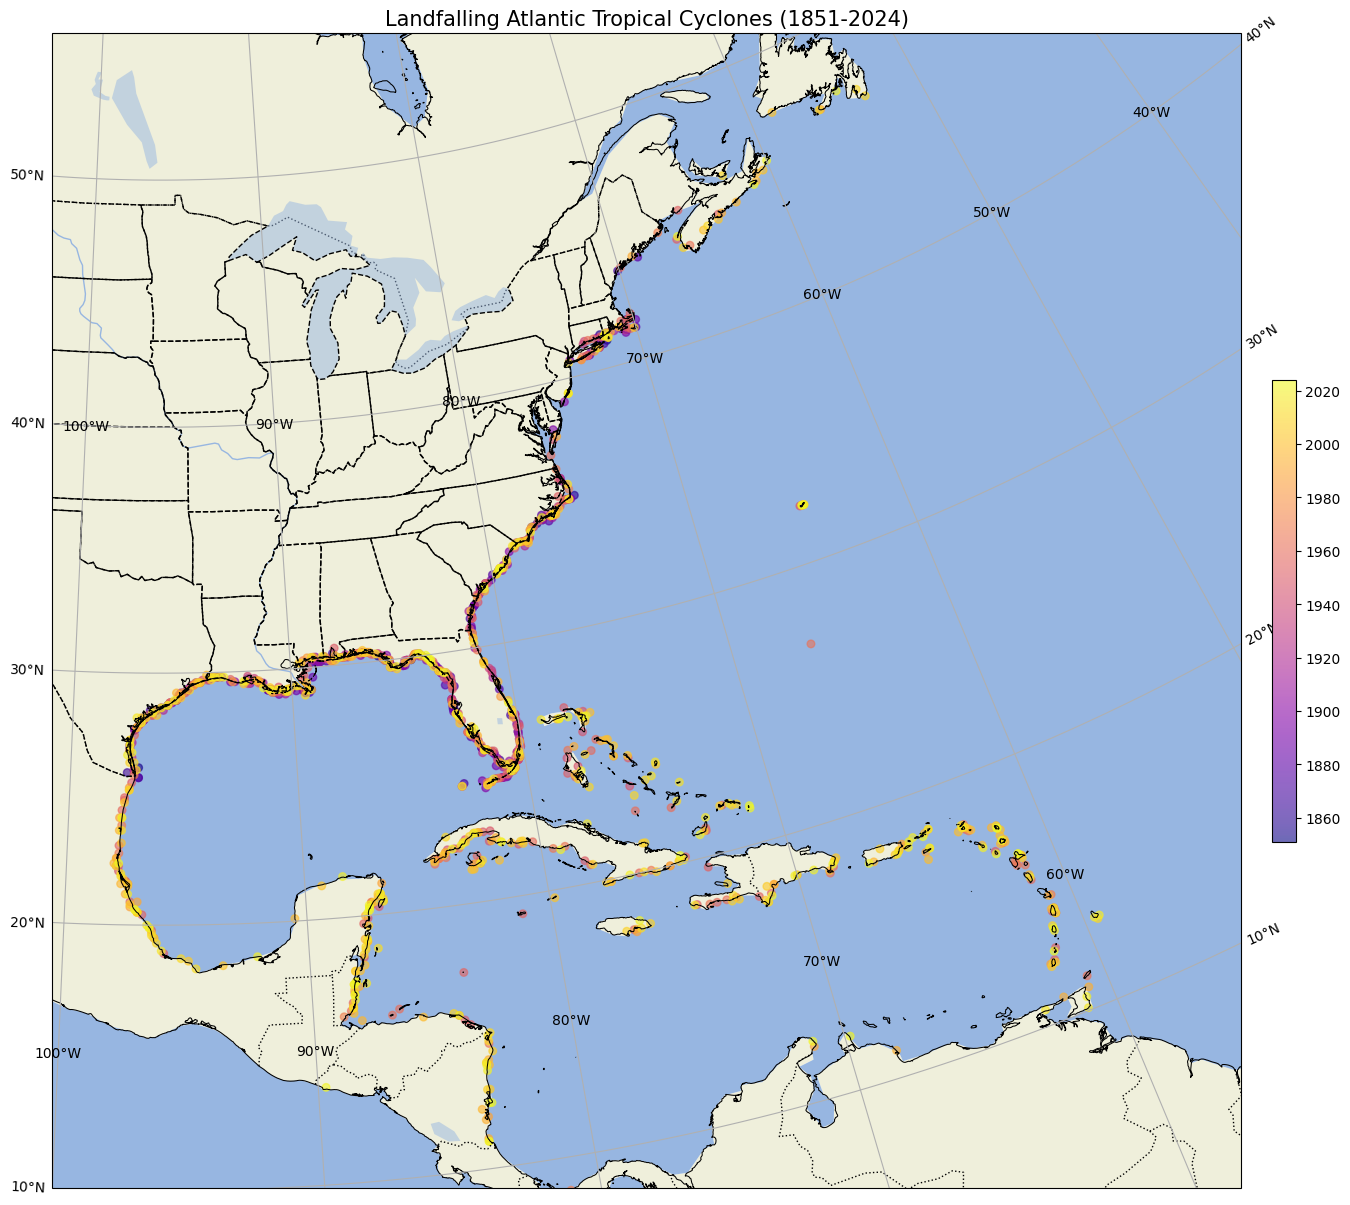

In [9]:
### Plotting the Landfalling Storms ###
fig, ax = plt.subplots(figsize= (20,15), subplot_kw = {'projection':ccrs.LambertConformal()})
## Defining Lat and Lon ##
Lat = Landfall_only['Lat'].str.strip('N').astype(float)
Lon = Landfall_only['lon'].str.strip('W').astype(float) * -1
## Converting Years to numeric values for color mapping ##
Landfall_only['year'] = pd.to_numeric(Landfall_only['year'].values)
Landfall_only['category'] = pd.to_numeric(Landfall_only['category'].values, errors = 'coerce')
## Making the Map##
ax.set_extent([-100, -55, 10, 50], crs=ccrs.PlateCarree())
map_data = ax.scatter(Lon, Lat,  c = Landfall_only['year'], 
                      cmap = 'plasma', s= 30, alpha = 0.6, 
                      transform=ccrs.PlateCarree())
cbar = plt.colorbar(map_data, ax=ax, shrink = 0.4, orientation = 'vertical', pad = 0.02)
## Adding features ##
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution = '10m', linewidth = 0.75) # Added very high res coastlines to see small islands
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels = True)
ax.add_feature(cfeature.STATES, linestyle = '--')
## Adding Title ##
plt.title('Landfalling Atlantic Tropical Cyclones (1851-2024)', fontsize = 15)


In [ ]:
## Create a new figure of the frequency of landfalls for various landfalling locations ##
# 1st: Landfalling frequency by locations by state, (Start with texas) - make a scatterplot with x and y axis showing frequency of landfalls by year
# x axis = year, y axis = frequency of landfalls

In [ ]:
## Creating figure for texas landfalling frequency ##
Texas_Landfalls_Lat = Landfall_only["Lat"].loc(Landfall_only['Lat'] >=  # Latitude range for Texas

Texas_Landfalls_Lat

ValueError: No axis named slice('29', '35', None) for object type Series